In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from network_model import *

import sys
#!{sys.executable} -m pip install [arg]


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [3]:
N = 500

In [4]:
g = nx.powerlaw_cluster_graph(n=N, m=2, p=0.5)

In [5]:
import time

timea = time.time()

W, I, communities, delta_pos, gamma_pos, success, allocations, C = simulation(
    NUM_AGENTS=N,
    STEPS=50,
    PROJECT_COST=0.001,
    graph=g,
    seed=123,
    DEFAULT_A=0.5
)

print(time.time()-timea)

103 communities.
Computing optimal portfolios...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Performing time stepping...


 18%|█▊        | 9/50 [00:00<00:02, 20.03it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Updating portfolios... (step = 10)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
 38%|███▊      | 19/50 [00:40<00:52,  1.69s/it]

Updating portfolios... (step = 20)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
 60%|██████    | 30/50 [01:19<00:36,  1.82s/it]

Updating portfolios... (step = 30)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
 80%|████████  | 40/50 [01:55<00:18,  1.81s/it]

Updating portfolios... (step = 40)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 50/50 [02:25<00:00,  2.90s/it]

194.06756782531738


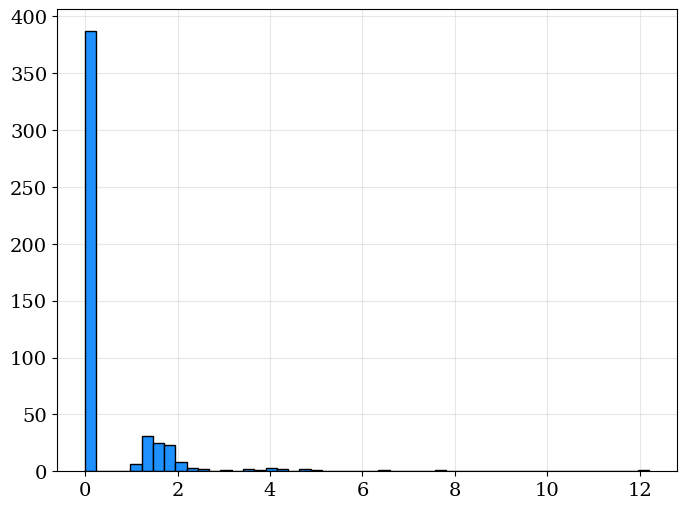

In [16]:
plt.hist(W[-1], bins=50, color="dodgerblue", edgecolor="k")
plt.show()

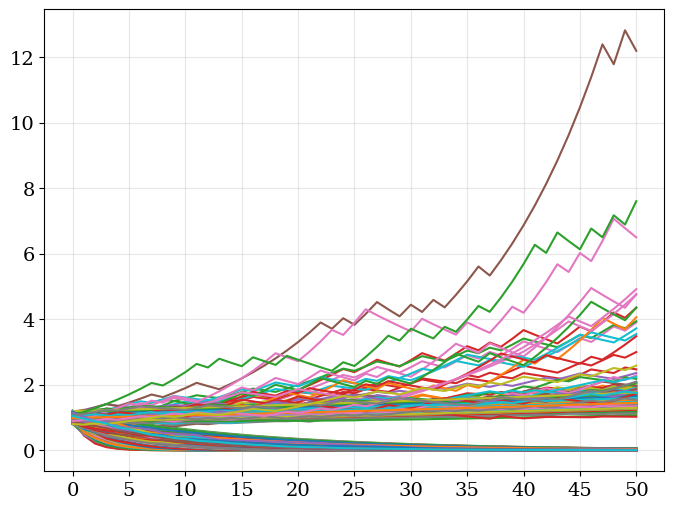

In [10]:
for i in range(W.shape[1]):
    plt.plot(W[:,i])
plt.xticks(np.arange(0, len(W), 5))
plt.show()

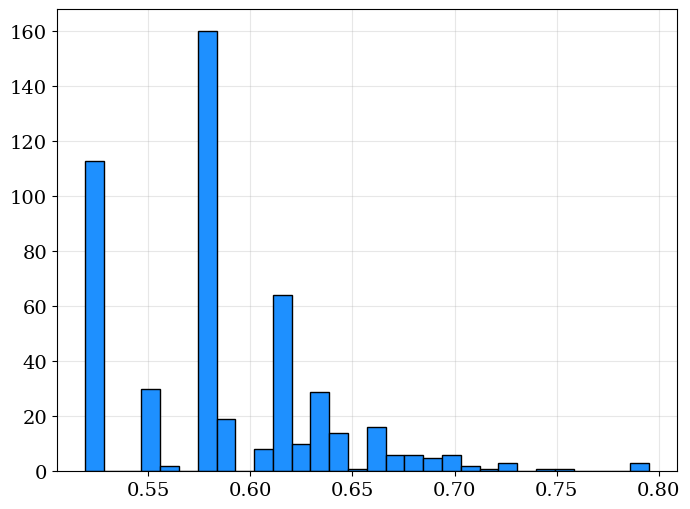

In [11]:
plt.hist(C[-1], color="dodgerblue", edgecolor="k", bins=30)
plt.show()

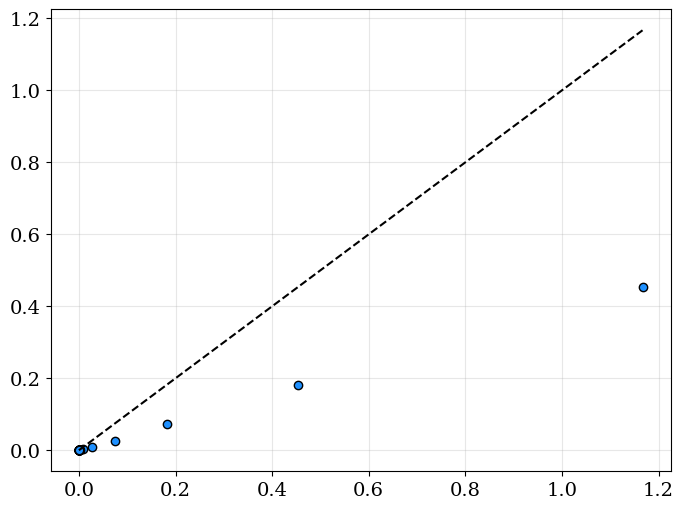

In [13]:
i = 10

x=[]
y=[]
for k in range(len(W)-1):
    x.append(W[k][i])
    y.append(W[k+1][i])

plt.scatter(x,y, color="dodgerblue", edgecolor="k")
plt.plot(np.linspace(min(x), max(x), 100), np.linspace(min(x), max(x), 100), color="k", linestyle="dashed")
plt.show()